In [347]:
import yfinance as yf
import mplfinance as mpf
from datetime import datetime, timedelta
import pandas as pd

# Set the parameters that we are interested in
ticker = input()
stock = yf.Ticker(ticker)

# Getting the different
current_datetime = datetime.today()
latest_date = stock.history().index[-1].strftime('%Y-%m-%d')
last_60_datetime = current_datetime - timedelta(days=59)
last_7_datetime = current_datetime - timedelta(days=8)

# converting datetime to date
current_date = current_datetime.strftime("%Y-%m-%d")
last_60_day = last_60_datetime.strftime("%Y-%m-%d")
last_7_day = last_7_datetime.strftime("%Y-%m-%d")

In [348]:
import math
# Options
# Get the options data for the specified ticker and expiration date
options = stock.option_chain("2023-05-19")

# Get the latest closing price
last_close = yf.download(ticker)['Close'][-1]

# Calculate the ask price for the "at the money" PUT option using the last_close price
# Re the first row of the the PUT which is higher than the last closing price
put = options.puts[options.puts['inTheMoney']== True].iloc[0]
#put_ask = put['ask']
put_iv = put['impliedVolatility']
# Caclulate the margin for the PUT option using ask_price/implied volatility
put_margin = last_close*put_iv*math.sqrt(7/365)

# Calculate the ask price for CALL using the last_close price
strike = put['strike']

# Calculate the ask price for the "strike price" CALL
call = options.calls[options.calls['strike']== strike].iloc[0]
call_ask = call['ask']
call_iv = call['impliedVolatility']

call_margin = last_close*call_iv*math.sqrt(7/365)

# Calculate the margin
margin = (call_margin + put_margin)/2

upper = last_close + margin
lower = last_close - margin


[*********************100%***********************]  1 of 1 completed


In [349]:
print(f"put margin: {put_margin}")
print(f"volatility: {put_iv*100}%")
print(f"original margin: {margin}")

def weighted(num):
    return num*10/100   

print(f"adjusted margin: {margin/(1+weighted(put_iv))}")

put margin: 6.840105831624085
volatility: 12.000391723632811%
original margin: 6.81401401127282
adjusted margin: 6.733212819875725


## 15 minutes timeframe

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


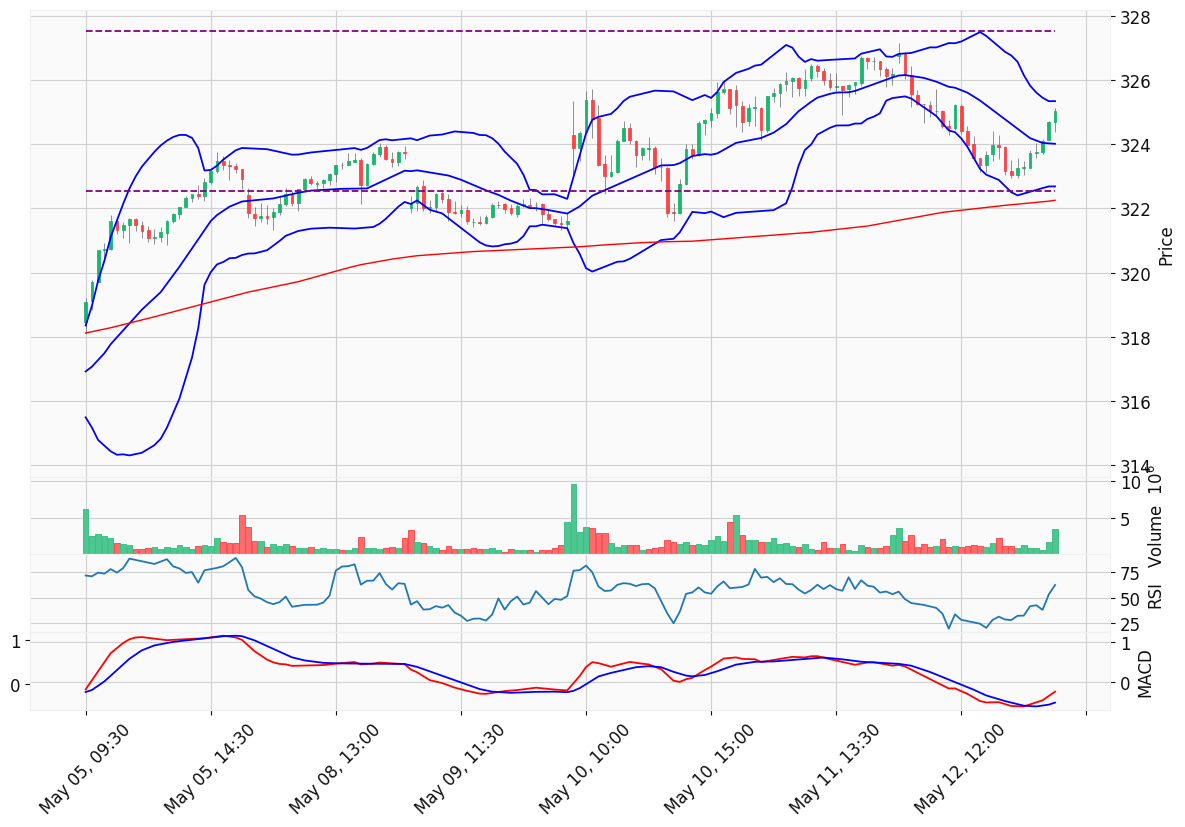

In [18]:
# Download historical data of QQQ from Yahoo Finance
raw_df = yf.download(ticker, start=last_60_day, interval = '15m' )
df = yf.download(ticker, start=last_7_day, interval = '15m')

# Define anchored VWAP parameters
# anchor_date = "2022-04-03"
# period = 20

# Calculate anchored VWAP
#df['AVWAP'] = raw_df[raw_df.index >= anchor_date].rolling(window=period).apply(lambda x: (x['Close'] * x['Volume']).sum() / x['Volume'].sum(), raw=True).dropna()

# Calculate Moving Averages
df['MA20'] = raw_df['Close'].rolling(window=20).mean()
df['MA50'] = raw_df['Close'].rolling(window=50).mean()
df['MA200'] = raw_df['Close'].rolling(window=200).mean()

# Calculate Relative Strength Index (RSI)
delta = raw_df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
fast_ema = 12
slow_ema = 26
signal = 9
exp1 = raw_df['Close'].ewm(span=fast_ema, adjust=False).mean()
exp2 = raw_df['Close'].ewm(span=slow_ema, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['signal_line'] = df['MACD'].ewm(span=signal, adjust=False).mean()

# Calculate Bollinger Bands
df['MA20_STD'] = raw_df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + 2 * df['MA20_STD']
df['Lower_Band'] = df['MA20'] - 2 * df['MA20_STD']

df['upper'] = upper
df['lower'] = lower

# Define style options
style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 12})

# Create the plot with indicators
mpf.plot(df, type='candle', volume=True, #mav = (fast_ema,slow_ema),
         addplot=[
            # Adding the RSI onto the plot
            mpf.make_addplot(df['RSI'], panel=2, ylabel='RSI'),
            # Adding the Bollinger Bands
            mpf.make_addplot(df[['Upper_Band', 'MA20', 'Lower_Band']], panel=0, color = 'blue', ylabel='Bollinger Bands'),
            
            # Moving average
            mpf.make_addplot(df['MA200'], panel=0,color='red',width = 1),
            # MACD
            mpf.make_addplot(df['MACD'], panel=3,color='red', ylabel = 'MACD'), 
            mpf.make_addplot(df['signal_line'], panel = 3,color='blue')

            # Adding daily expected moves
            , mpf.make_addplot(df['upper'], type='line', linestyle='--', color='purple')
            , mpf.make_addplot(df['lower'], type='line', linestyle='--', color='purple')

            # Adding achorVWAP
            #, mpf.make_addplot(df['AVWAP'], color = 'orange', panel = 0)

            ], 
         panel_ratios=(6,1), figsize = (15,10), style = style
        )


## Daily timeframe

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


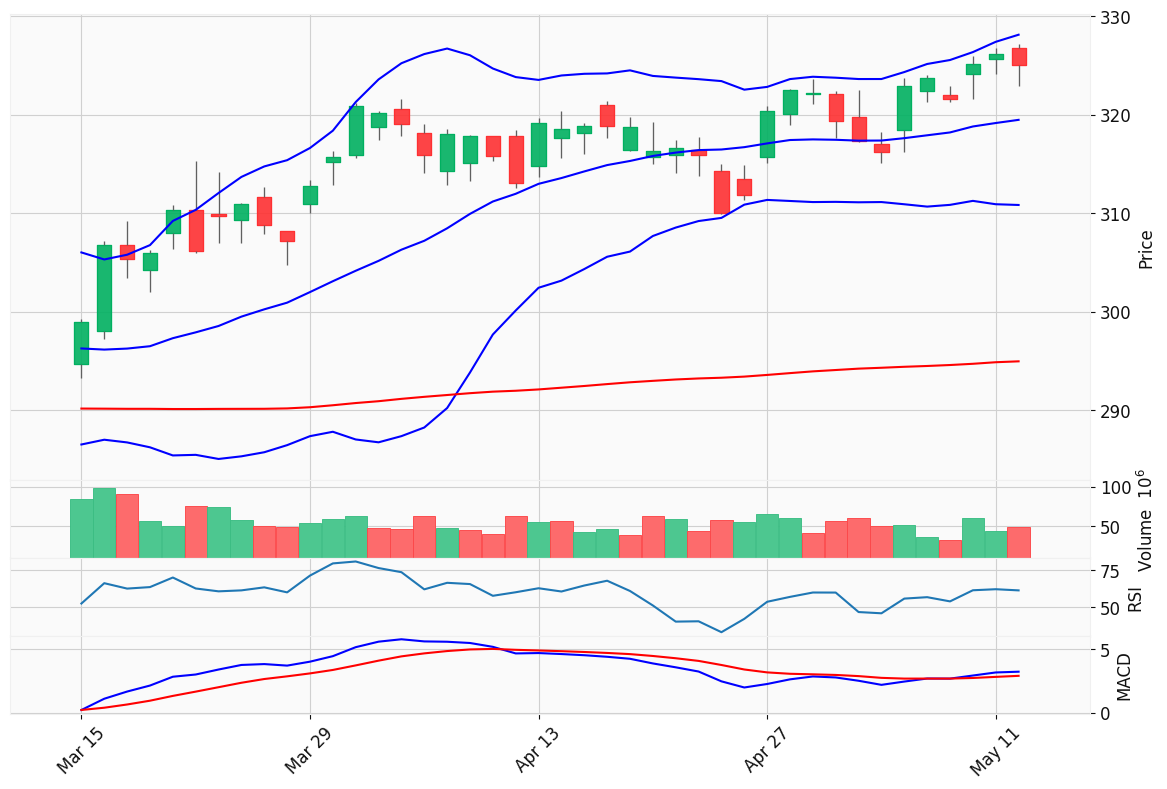

In [19]:
# Download historical data of QQQ from Yahoo Finance
raw_df = yf.download(ticker, start='2022-01-01', interval = '1d' )
df = yf.download(ticker, start=last_60_day, interval = '1d')

# Calculate Moving Averages
df['MA20'] = raw_df['Close'].rolling(window=20).mean()
df['MA50'] = raw_df['Close'].rolling(window=50).mean()
df['MA200'] = raw_df['Close'].rolling(window=200).mean()

# Calculate Relative Strength Index (RSI)
delta = raw_df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Calculate Moving Average Convergence Divergence (MACD)
fast_ema = 12
slow_ema = 26
signal = 9
exp1 = raw_df['Close'].ewm(span=fast_ema, adjust=False).mean()
exp2 = raw_df['Close'].ewm(span=slow_ema, adjust=False).mean()
df['MACD'] = exp1 - exp2
df['signal_line'] = df['MACD'].ewm(span=signal, adjust=False).mean()

# Calculate Bollinger Bands
df['MA20_STD'] = raw_df['Close'].rolling(window=20).std()
df['Upper_Band'] = df['MA20'] + 2 * df['MA20_STD']
df['Lower_Band'] = df['MA20'] - 2 * df['MA20_STD']

df['upper'] = upper
df['lower'] = lower

# Define style options
style = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.size': 12})

# Create the plot with indicators
mpf.plot(df, type='candle', volume=True, #mav = (fast_ema,slow_ema),
         addplot=[
            # Adding the RSI onto the plot
            mpf.make_addplot(df['RSI'], panel=2, ylabel='RSI',width = 1.5),
            # Adding the Bollinger Bands
            mpf.make_addplot(df[['Upper_Band', 'MA20', 'Lower_Band']], panel=0, color = 'blue', width = 1.5 , ylabel='Bollinger Bands'),
            
            # Moving average
            mpf.make_addplot(df['MA200'], panel=0,color='red',width = 1.5),
            # MACD
            mpf.make_addplot(df['MACD'], panel=3,color='blue', width = 1.5 ,ylabel = 'MACD'), 
            mpf.make_addplot(df['signal_line'], panel = 3, width =1.5, color='red')

            # Adding daily expected moves
            #,mpf.make_addplot(df['upper'], type='line', linestyle='--', color='purple')
            #,mpf.make_addplot(df['lower'], type='line', linestyle='--', color='purple')

            ], 
         panel_ratios=(6,1), figsize = (15,10), style = style
        )